In [1]:
from carabao.neuron import Cell,toy
from numpy import array,zeros

class Layer:
    def __init__(self,mon,G,K,P,xlabel=None):
        m,n,d,s = K.shape
        cells = []
        self.eta = 0.5             # synaptic threshold
        self.theta = 2             # spiking threshold
        self.delta = (0.2,0.2)     # learning deltas

           # build up FORTRAN order, so row index (i) must run faster
        
        for j in range(0,n):       # FORTRAN  order: column (j) index runs slower
            for i in range(0,m):   # and row index (i) runs faster
                k = j*m + i
                cell = Cell(mon,k,G[j],K[i,j],P[i,j])
                cell.syn.parameter(self.eta,self.theta,self.delta)
                cells.append(cell)
                
        self.cells = array([cells]).reshape(m,n,order='F')
        self.mon = mon
        self.mn = (m,n)
        self.xlabel = xlabel

    def phase(self,ph,u,c,subplot=0):
        m,n = self.mn
        for i in range(0,m):
            for j in range(0,n):
                c = self.cells[i,j].phase(ph,u[j],c)
        if subplot > 0:
            lay.plot(self.mon,subplot=subplot)
        return c

    def process(self,u,c,index=None,all=False):
        """
        Layer.process():  process one iteration step (all 4 phases) and plot
        >>> lay = Layer(mon,G,K,P)
        >>> lay.process(u,c)                 # silent processing (no logs)
        >>> lay.process(u,c,[[4]],label)     # change log of cell[4]
        >>> lay.process(u,c,[[4,5]],"",True) # log all of cell[4] and cell[5]
        """
        def log(phase,index,label,all):
            if isinstance(index,list) and len(index) > 0:
                self.log(index[phase],label,all)
        
        if index is not None:
            print("u:",u);  print("c:",c)
        log(0,index,"at begin",all)
            
        c = self.phase(1,u,c,subplot=1); 
        log(1,index,"after phase 1 (1st row): b = 0, y = u*x",all)
        
        c = self.phase(2,u,c)
        log(2,index,"after phase 2: b = u*(sum(v)==0)",all)

        #c = self.phase(3,u,c,subplot=2)
        c = self.phase(3,u,c)
        log(3,index,"after phase 3: y = u*(x|b), P' = sat(P+y*L)",all)

        #c = self.phase(4,u,c,subplot=3)
        c = self.phase(4,u,c,subplot=2)
        log(4,index,"after phase 4 (2nd row): x = max(S(c,P)), L' = L(c,S(c,P))",all)
        return c

    def log(self,index,label="",all=False):
        """
        Layer.log(): log a list of nodes
        >>> lay.log([5])                 # change log of cell[5]
        >>> lay.log([5],"before")        # change log cell[5] with label "before"
        >>> lay.log([1,2,3],"",all=True) # log all of cell[1],cell[2],cell[3]
        """
        for k in index:
            self.mon.log(self[k],"cell[%g] %s" % (k,label),all)

    
    def plot(self,mon,subplot=1):
        cells = self.cells; 
        m,n = self.mn;  mm,nn = self.mon.mn()
        oy = 5.55;  ox = -0.3
        for i in range(0,m):
            for j in range(0,n):
                x = j; y = i + (subplot-1)*2.3 - 0.5
                cell = cells[i,j]
                mon.plot(cell,y,x,index=cell.k)
                #mon.text(ox+x,oy-y,"%g" % (j*m+i),size=7)
        if self.xlabel is not None:
            for j in range(0,n):
                mon.xlabel(j,self.xlabel[j])

    def set_u(self,u):
        m,n = self.mn
        for i in range(0,m):
            for j in range(0,n):
                self.cells[i,j].set(u=u[j])

    def set(self,u=None):
        if u is not None: self.set_u(u)

    def connect(self,i,j,u,row=None):
        """
        Layer.connect(): setup connection topology and permanences for prediction
            lay.connect(i,j,row=1,u=token['likes'])
        """
        row = i if row is None else row
        cells = self.cells
        Kij = cells[i,j].syn.K
        Pij = cells[i,j].P*1.0
        m,n = cells.shape
        
        mu = 0;  nu = 0;  ii = row;
        for jj in range(0,len(u)):
            if u[jj] > 0:
                k = ii + m*jj
                Kij[mu,nu] = k
                Pij[mu,nu] = 0.5
                #print("Pij[%g,%g] ="%(mu,nu),Pij[mu,nu])
                nu += 1
        while nu < Kij.shape[1]:
            Pij[mu,nu] = 0.45;  nu += 1
        cells[i,j].syn.K = Kij
        cells[i,j].P = cells[i,j]._P = Pij
        print("connect => K%g:"%self.kappa(i,j),repr(cells[i,j].syn.K))
        print("connect => P%g:"%self.kappa(i,j),repr(cells[i,j].P))

    def __getitem__(self,k):
        i,j = self.kappa(k)
        return self.cells[i,j]
        
    def kappa(self,i,j=None):
        """
        Layer.kappa(): convert between matrix indices [i,j] and array index (k)
            k = layer.kappa(i,j)   # k = i+m*j
            i,j = layer.kappa(k)   # i = k % m, j = k // m
        """
        m,n = self.cells.shape
        if j is None:
            k = i;  return (k%m,k//m)
        else:
            return i + m*j
            

ModuleNotFoundError: No module named 'carabao'

In [2]:
# layer: tiny HTM layer

from numpy import array,transpose
from carabao.neuron import toy
from carabao.util import repr
from carabao.screen import Monitor

G,K,P,c,token,xlabel,minicol = toy('tiny')
print("K:",K.shape,"P:",P.shape,"G:",G.shape)

height = 1+2.6*K.shape[0];  
height = 1+1.4*K.shape[0];  width = K.shape[1]


ModuleNotFoundError: No module named 'carabao'

In [ ]:
mon = Monitor(height,width)
lay = Layer(mon,G,K,P,xlabel=xlabel)

#===========================================================================
# let's go now and process sequence #0: 'Mary likes to sing'
#===========================================================================

seq = 0  # sequence number for 'Mary likes to sing' 
lay.connect(seq,minicol['likes'],token['Mary'])
c = lay.process(token['Mary'],c,[[0,4],[4],[4],[4],[4]],all=False)

In [ ]:
mon = Monitor(height,width)
lay.connect(seq,minicol['to'],token['likes'])
c = lay.process(token['likes'],c,[[],[4],[4],[4],[4]],all=False)


In [ ]:
mon = Monitor(height,width)
lay.connect(seq,minicol['sing'],token['to'])
c = lay.process(token['to'],c,[[6],[6],[6],[6],[6]])


In [ ]:
mon = Monitor(height,width)
c = lay.process(token['sing'],c,[[4],[4],[4],[4],[4]])


In [ ]:
#===========================================================================
# let's process next sequence #1: 'John likes to dance'
#===========================================================================

seq = 1  # sequence number for 'John likes to dance'
mon = Monitor(height,width)
lay.connect(seq,minicol['likes'],token['John'])
c = lay.process(token['John'],c,[[5],[5],[5],[5],[5]])


In [ ]:
mon = Monitor(height,width)
lay.connect(seq,minicol['to'],token['likes'])
c = lay.process(token['likes'],c,[[7],[7],[7],[7],[7]])


In [ ]:
mon = Monitor(height,width)
lay.connect(seq,minicol['dance'],token['to'])
c = lay.process(token['to'],c,[[11],[11],[11],[11],[11]])


u: [0, 0, 0, 0, 0, 1, 1]
c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] at begin
--------------------------------------------------------------
   k7: 7 , g: [6 7] , eta: 0.5
   K7: [    5   13    2    3    4;     5    6    7    8    9]
   P7: [  0.7  0.7  .25  .25  .25;     0    0    0    0    0]
   V7: [    0    1    0    0    0;     0    0    1    0    0]
   W7: [    1    1    0    0    0;     0    0    0    0    0]
   E7: [    0    1    0    0    0;     0    0    0    0    0]
   b7: 0 , v7: [0 1]
   s7: [0 0] (||E||=1, theta:2)
   u7: 1 , y7: 1 , x7: 0
   c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] after phase 1 (1st row): b = 0, y = u*x
--------------------------------------------------------------
   u7: 0 , y7: 0 , x7: 0
   c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
--------------------------------------------------------------
cell[7]

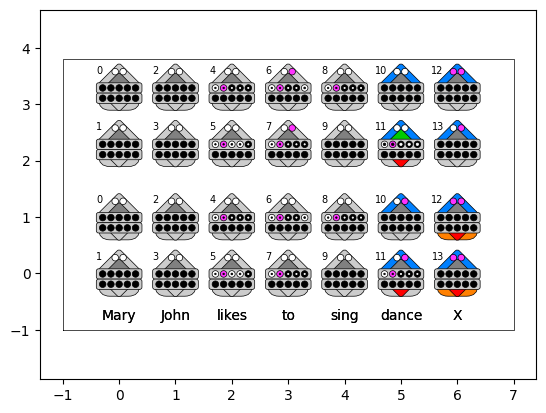

In [10]:
mon = Monitor(height,width)
c = lay.process(token['dance'],c,[[7],[7],[7],[7],[7]])
